# Projeto — GeoGuardian

**FIAP** — _Faculdade de Informática e Administração Paulista_  
**Matéria:** _Disruptive Architectures: IoT, IoB & Generative AI_  
**Turma:** _2TDSPW_  
**Professor:** _Alberto Messias_

## **Integrantes**

- Cauã Marcelo Machado — _RM 558024_
- Gabriel Lima Silva — _RM 556773_
- Felipe Melo de Sousa — _RM 556099_

# **Fase 1 — Geração do Dataset Simulado**

In [7]:
# Importação de Bibliotecas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)


In [8]:
# Simulação de um dataset com dados de sensores ambientais
np.random.seed(42)

n_amostras = 1000

data = pd.DataFrame({
    'nivel_agua_cm': np.random.uniform(50, 400, n_amostras),
    'umidade_solo_percentual': np.random.uniform(10, 100, n_amostras),
    'inclinacao_terreno_graus': np.random.uniform(0, 45, n_amostras),
    'historico_ocorrencias': np.random.randint(0, 5, n_amostras)
})

In [9]:
# Geração da variável alvo (risco)

def calcular_risco(row):
    score = 0
    if row['nivel_agua_cm'] > 300:
        score += 2
    elif row['nivel_agua_cm'] > 200:
        score += 1

    if row['umidade_solo_percentual'] > 80:
        score += 2
    elif row['umidade_solo_percentual'] > 60:
        score += 1

    if row['inclinacao_terreno_graus'] > 30:
        score += 2
    elif row['inclinacao_terreno_graus'] > 15:
        score += 1

    score += row['historico_ocorrencias'] * 0.5

    if score >= 5:
        return 'Alto'
    elif score >= 3:
        return 'Médio'
    else:
        return 'Baixo'

data['risco'] = data.apply(calcular_risco, axis=1)

print(data.head())

   nivel_agua_cm  umidade_solo_percentual  inclinacao_terreno_graus  \
0     181.089042                26.661964                 11.776756   
1     382.750007                58.771085                 11.114046   
2     306.197880                88.565125                 40.781456   
3     259.530469                75.900240                 11.229579   
4     104.606524                82.590503                 12.237738   

   historico_ocorrencias  risco  
0                      2  Baixo  
1                      0  Baixo  
2                      4   Alto  
3                      2  Médio  
4                      1  Baixo  


<ipython-input-10-08e6896aae7d>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='risco', data=data, palette='Set2')


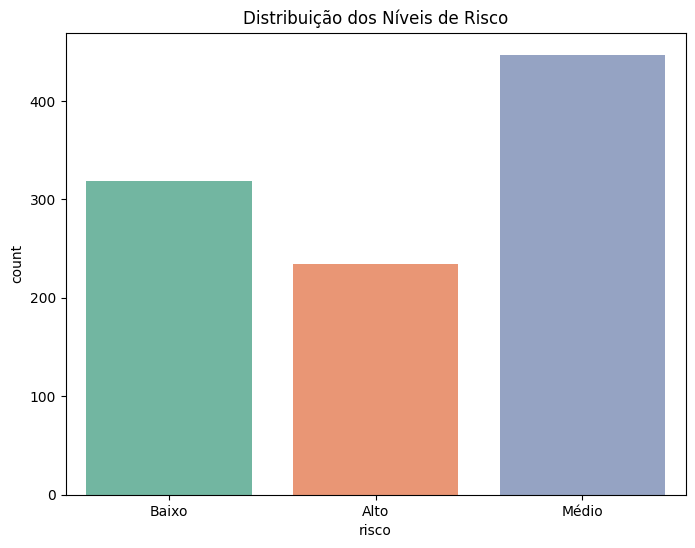

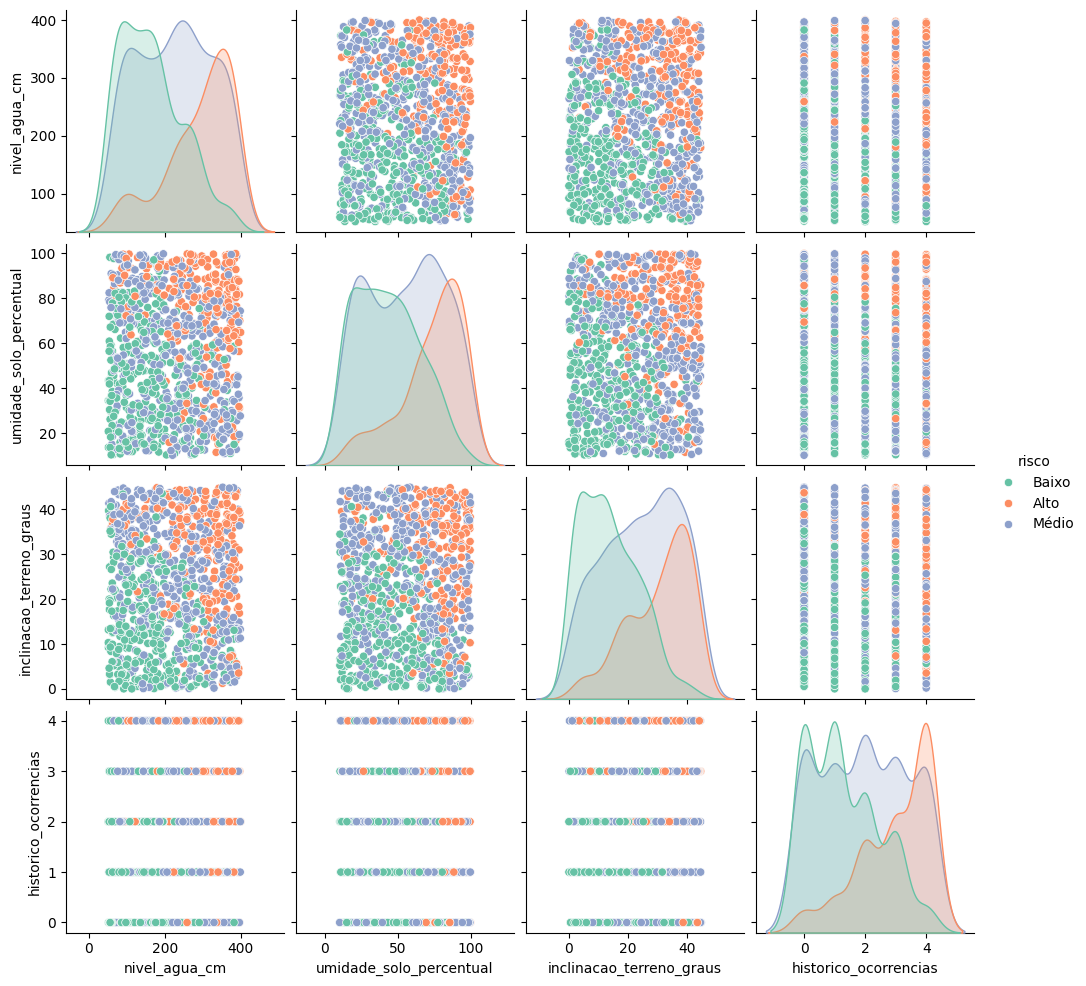

In [10]:
# Análise Exploratória

plt.figure(figsize=(8,6))
sns.countplot(x='risco', data=data, palette='Set2')
plt.title('Distribuição dos Níveis de Risco')
plt.show()

sns.pairplot(data, hue='risco', palette='Set2')
plt.show()


In [5]:

X = data.drop('risco', axis=1)
y = data['risco']

y = y.map({'Baixo': 0, 'Médio': 1, 'Alto': 2})

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [ ]:

modelo = RandomForestClassifier(n_estimators=100, random_state=42)
modelo.fit(X_train, y_train)


In [ ]:

y_pred = modelo.predict(X_test)

print("Acurácia:", accuracy_score(y_test, y_pred))
print("Precision:", precision_score(y_test, y_pred, average='weighted'))
print("Recall:", recall_score(y_test, y_pred, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred, average='weighted'))

print("\nClassification Report:\n", classification_report(y_test, y_pred))


In [ ]:

mat = confusion_matrix(y_test, y_pred)

sns.heatmap(mat, annot=True, fmt="d", cmap="Blues", xticklabels=['Baixo', 'Médio', 'Alto'], yticklabels=['Baixo', 'Médio', 'Alto'])
plt.xlabel('Previsto')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()


In [ ]:

importancias = pd.Series(modelo.feature_importances_, index=X.columns)
importancias.sort_values().plot(kind='barh', color='teal')
plt.title('Importância das Variáveis no Modelo')
plt.show()
